In [65]:
import os
import pandas as pd
import json
from pandas import json_normalize
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
def process_real_data(csv_file_path):
    
    # read the data
    final_trial_500_points = pd.read_csv(csv_file_path).drop(columns=['id'])
    
    # extract the observations
    observations = json_normalize(final_trial_500_points['observation'].apply(json.loads))
    
    # extract the real and predicted classes
    df_real_pred = final_trial_500_points[['observation_id', 'pred', 'true_class']].rename(columns={'observation_id': 'id'})
    
    # concatenate the dataframes
    df = pd.concat([observations, df_real_pred], axis=1)
    
    # Drop the duplicated 'id' column after concatenation
    df = df.loc[:,~df.columns.duplicated()]
    
    # Rename columns for clarity
    df = df.rename(columns={'true_class': 'is_recid'})
    
    return df
    
    
csv_file_path = os.path.join('..', 'data', 'final_trial_500_points.csv')

df = process_real_data(csv_file_path)

df.head()

,id,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,age_group,weights_race,pred,is_recid
0,6216,Male,Caucasian,0,0,1,1,Felony,<25,0.49,True,0
1,6217,Male,Hispanic,0,0,0,0,Felony,25-34,1.87,False,0
2,6218,Male,Other,0,0,0,0,Misdemeanor,<25,3.14,False,1
3,6219,Male,African-American,0,0,0,5,Misdemeanor,25-34,0.33,False,0
4,6221,Male,African-American,0,0,0,0,Felony,<25,0.33,False,1


In [52]:
X = df.drop(columns=['weights_race','pred','is_recid'])

# convert id to int and age_group to category
X['id'] = X['id'].astype('int64')
X['age_group'] = X['age_group'].astype('category')

y = df['is_recid']

In [53]:
# load models
with open(os.path.join('..','data', 'pipeline.pickle'), 'rb') as fh:
    loaded_pipe = pickle.load(fh)

# assert that the column names are the same
# Load the column names from the file
with open(os.path.join('..','data', 'columns.json'), 'r') as fh:
    loaded_columns = json.load(fh)

with open(os.path.join('..','data', 'dtypes.pickle'), 'rb') as fh:
    loaded_dtypes = pickle.load(fh)

In [54]:
# predict the recidivism
y_pred = loaded_pipe.predict(X)

# calculate the accuracy
accuracy = (y == y_pred).mean()

In [55]:
accuracy

0.6633266533066132

In [56]:
# Function to get privileged and unprivileged groups based on protected attribute
def get_groups(protected_attribute, protected_values):
    if protected_attribute == 'race':
        privileged_group = (protected_values == 'Caucasian')
        unprivileged_group = (protected_values == 'African-American')
    elif protected_attribute == 'sex':
        privileged_group = (protected_values == 'Male')
        unprivileged_group = (protected_values == 'Female')
    elif protected_attribute == 'age_group':
        privileged_group = (protected_values == '<25')
        unprivileged_group = (protected_values == '55+')
    else:
        raise ValueError(f"Protected attribute '{protected_attribute}' not recognized.")

    return privileged_group, unprivileged_group

# Function to calculate disparate impact
def calculate_disparate_impact(y_true, y_pred, protected_attribute, df):
    # Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
    # The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.
    # Fairness for this metric is between 0.8 and 1.25
    
    """
    Calculates the Disparate Impact metric for fairness assessment.

    Parameters:
    - y_true: True labels or outcomes.
    - y_pred: Predicted probabilities or outcomes from a model.
    - protected_attribute: Name of the column in `df` that contains the protected attribute.
    - df: DataFrame containing the protected attribute values.

    Returns:
    - disparate_impact: Disparate Impact metric. NaN if there are no samples in one of the groups.
    """
    
    protected_values = df.loc[y_true.index, protected_attribute]
    
    privileged_group, unprivileged_group = get_groups(protected_attribute, protected_values)
    
    #if protected_attribute == 'race':
    #    privileged_group = (protected_values == 'Caucasian')
    #    unprivileged_group = (protected_values == 'African-American')
    #elif protected_attribute == 'sex':
    #    privileged_group = (protected_values == 'Male')
    #    unprivileged_group = (protected_values == 'Female')
    #elif protected_attribute == 'age_group':
    #    privileged_group = (protected_values == '<25')
    #    unprivileged_group = (protected_values == '55+')
    #else:
    #    raise ValueError(f"Unsupported protected attribute: {protected_attribute}")
    
    # Check if any samples belong to the privileged or unprivileged group
    if np.sum(privileged_group) == 0 or np.sum(unprivileged_group) == 0:
        return np.nan  # Return NaN if there are no samples in one of the groups
    
    # Calculate the selection rate for each group if they are non-empty
    privileged_selection_rate = y_pred[privileged_group].mean() if np.sum(privileged_group) > 0 else np.nan
    unprivileged_selection_rate = y_pred[unprivileged_group].mean() if np.sum(unprivileged_group) > 0 else np.nan
    
    # Disparate impact is the ratio of the unprivileged to privileged selection rates
    disparate_impact = unprivileged_selection_rate / privileged_selection_rate
    
    return disparate_impact

# Function to calculate equal opportunity
def calculate_equal_opportunity(y_true, y_pred, protected_attribute, df):
    # Metric computed as the difference of true positive rates between the unprivileged and the privileged groups. 
    # The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and > 0 implies higher benefit for the unprivileged group.
    # Fairness for this metric is between -0.1 and 0.1
    
    """
    Calculates the Equal Opportunity metric for fairness assessment.

    Parameters:
    - y_true: True labels or outcomes.
    - y_pred: Predicted probabilities or outcomes from a model.
    - protected_attribute: Name of the column in `df` that contains the protected attribute.
    - df: DataFrame containing the protected attribute values.

    Returns:
    - equal_opportunity: Equal Opportunity metric. NaN if there are no samples in one of the groups.
    """
    
    # Use only the rows corresponding to the test set
    protected_values = df.loc[y_true.index, protected_attribute]
    
    # Define privileged and unprivileged groups based on the protected attribute
    if protected_attribute == 'race':
        privileged_group = (protected_values == 'Caucasian')
        unprivileged_group = (protected_values == 'African-American')
    elif protected_attribute == 'sex':
        privileged_group = (protected_values == 'Male')
        unprivileged_group = (protected_values == 'Female')
    elif protected_attribute == 'age_group':
        privileged_group = (protected_values == '<25')
        unprivileged_group = (protected_values == '55+')
    else:
        raise ValueError(f"Unsupported protected attribute: {protected_attribute}")
    
    # Calculate true positive rates (TPR) for each group
    tpr_privileged = ((y_pred == 1) & (y_true == 1) & privileged_group).sum() / (y_true[privileged_group] == 1).sum()
    tpr_unprivileged = ((y_pred == 1) & (y_true == 1) & unprivileged_group).sum() / (y_true[unprivileged_group] == 1).sum()
    
    # Equal opportunity difference
    equal_opportunity = tpr_unprivileged - tpr_privileged
    
    return equal_opportunity

In [63]:
# calculate disparate_impact
disparate_impact_race = calculate_disparate_impact(y, y_pred, 'race', df)
disparate_impact_sex = calculate_disparate_impact(y, y_pred,'sex', df)
disparate_impact_age_group = calculate_disparate_impact(y, y_pred, 'age_group', df)

equal_opportunity_race = calculate_equal_opportunity(y, y_pred,'race', df)
equal_opportunity_sex = calculate_equal_opportunity(y, y_pred,'sex', df)
equal_opportunity_age_group = calculate_equal_opportunity(y, y_pred,'age_group', df)

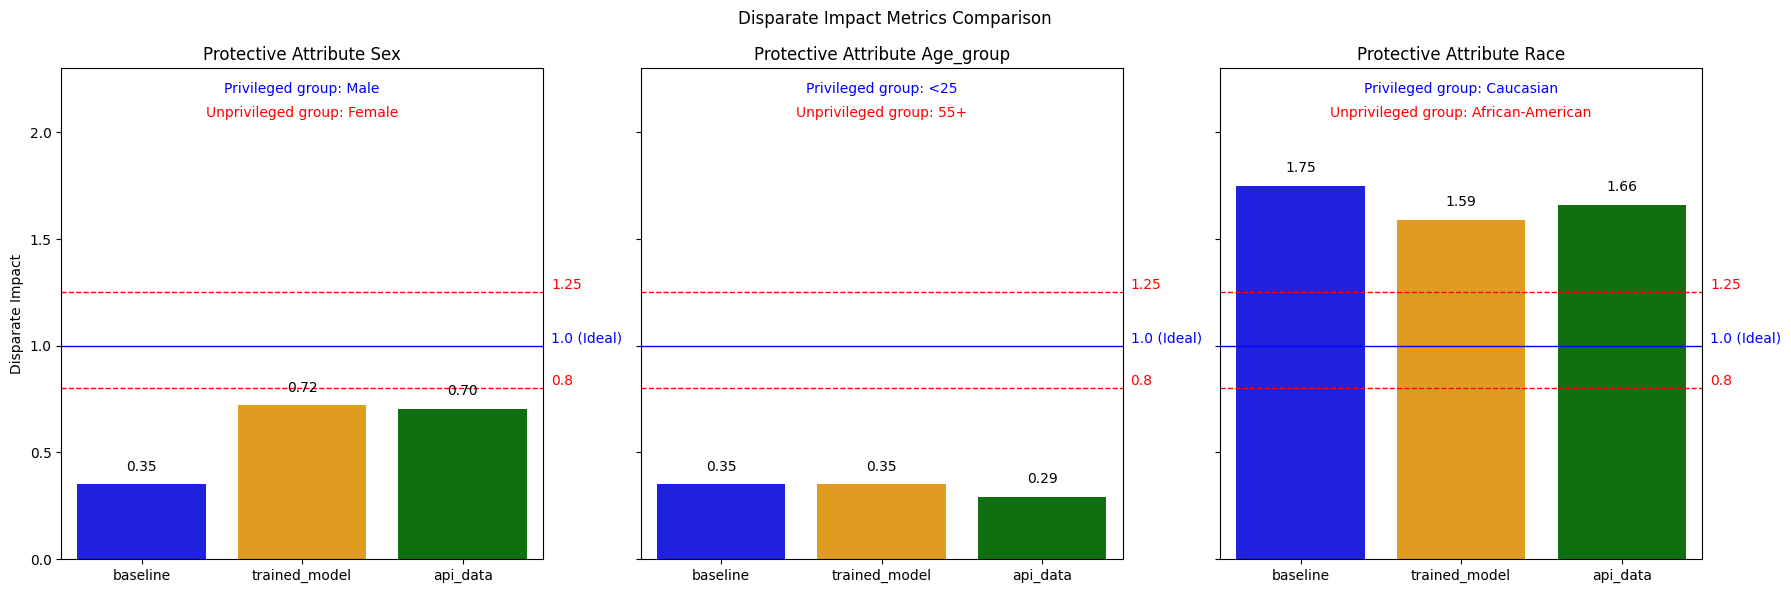

In [77]:
bets_values_for_disparate_impact = {
    'sex': {
        'baseline': 0.35,
        'trained_model': 0.72,
        'api_data': disparate_impact_sex,
        
    },
    'age_group': {
        'baseline': 0.35,
        'trained_model': 0.35,
        'api_data': disparate_impact_age_group,
    },
    'race': {
        'baseline': 1.75,
        'trained_model': 1.59,
        'api_data': disparate_impact_race,
        
    }
}


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plt.suptitle("Disparate Impact Metrics Comparison",
             fontsize=12, ha='center')

# Iterate over each attribute ('sex', 'age_group', 'race')
for idx, key in enumerate(bets_values_for_disparate_impact.keys()):
    values_dict = bets_values_for_disparate_impact[key]

    # Plotting bars for each value type
    bars = sns.barplot(ax=axs[idx], x=list(values_dict.keys()), y=list(values_dict.values()), hue=list(values_dict.keys()),palette=['blue', 'orange','green'])

    # Add values on top of each bar
    for bar, value in zip(bars.patches, values_dict.values()):
        height = bar.get_height()
        axs[idx].text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    axs[idx].set_ylabel('Disparate Impact')
    axs[idx].set_title(f'Protective Attribute {key.capitalize()}')

    # Draw lines for ideal value and thresholds on the right side
    axs[idx].axhline(0.8, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(1.25, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(1.0, color='blue', linestyle='-', linewidth=1)  # Ideal value line
    
    axs[idx].text(2.55, 0.8, '0.8', color='red', ha='left', va='bottom')
    axs[idx].text(2.55, 1.25, '1.25', color='red', ha='left', va='bottom')
    axs[idx].text(2.55, 1.0, '1.0 (Ideal)', color='blue', ha='left', va='bottom')

    # Add attribute-specific text
    if key == 'race':
        privileged_text = "Privileged group: Caucasian"
        unprivileged_text = "Unprivileged group: African-American"
    elif key == 'sex':
        privileged_text = "Privileged group: Male"
        unprivileged_text = "Unprivileged group: Female"
    elif key == 'age_group':
        privileged_text = "Privileged group: <25"
        unprivileged_text = "Unprivileged group: 55+"

    axs[idx].text(0.5, 0.95, privileged_text, transform=axs[idx].transAxes, ha='center', fontsize=10, color='blue')
    axs[idx].text(0.5, 0.9, unprivileged_text, transform=axs[idx].transAxes, ha='center', fontsize=10, color='red')

    axs[idx].set_ylim(0, 2.3)  # Set y-axis limit for consistency

# Adjust layout and show plot
plt.tight_layout()
plt.show()

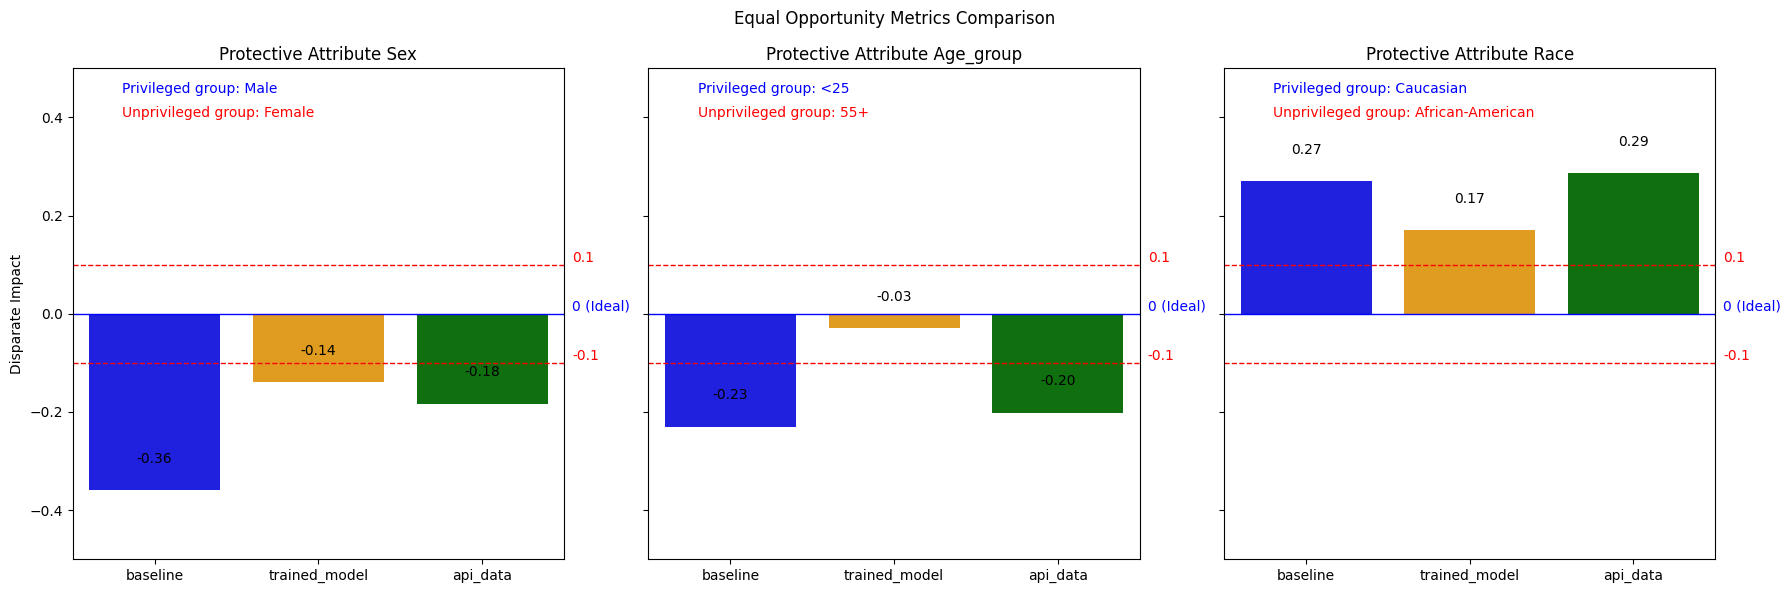

In [76]:
bets_values_for_equal_opportunity = {
    'sex': {
        'baseline': -0.36,
        'trained_model': -0.14,
        'api_data': equal_opportunity_sex,
        
    },
    'age_group': {
        'baseline': -0.23,
        'trained_model': -0.03,
        'api_data': equal_opportunity_age_group,
    },
    'race': {
        'baseline': 0.27,
        'trained_model': 0.17,
        'api_data': equal_opportunity_race,
        
    }
}


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plt.suptitle("Equal Opportunity Metrics Comparison",
             fontsize=12, ha='center')

# Iterate over each attribute ('sex', 'age_group', 'race')
for idx, key in enumerate(bets_values_for_equal_opportunity.keys()):
    values_dict = bets_values_for_equal_opportunity[key]

    # Plotting bars for each value type
    bars = sns.barplot(ax=axs[idx], x=list(values_dict.keys()), y=list(values_dict.values()), hue=list(values_dict.keys()),palette=['blue', 'orange','green'])

    # Add values on top of each bar
    for bar, value in zip(bars.patches, values_dict.values()):
        height = bar.get_height()
        axs[idx].text(bar.get_x() + bar.get_width() / 2.0, height + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    axs[idx].set_ylabel('Disparate Impact')
    axs[idx].set_title(f'Protective Attribute {key.capitalize()}')

    # Draw lines for ideal value and thresholds
    axs[idx].axhline(0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(-0.1, color='red', linestyle='--', linewidth=1)
    axs[idx].axhline(0, color='blue', linestyle='-', linewidth=1)  # Ideal value line
    
    # Annotate the lines
    axs[idx].text(2.55, 0.1, '0.1', color='red', ha='left', va='bottom')
    axs[idx].text(2.55, -0.1, '-0.1', color='red', ha='left', va='bottom')
    axs[idx].text(2.55, 0, '0 (Ideal)', color='blue', ha='left', va='bottom')

    # Add attribute-specific text
    if key == 'race':
        privileged_text = "Privileged group: Caucasian"
        unprivileged_text = "Unprivileged group: African-American"
    elif key == 'sex':
        privileged_text = "Privileged group: Male"
        unprivileged_text = "Unprivileged group: Female"
    elif key == 'age_group':
        privileged_text = "Privileged group: <25"
        unprivileged_text = "Unprivileged group: 55+"

    axs[idx].text(0.1, 0.95, privileged_text, transform=axs[idx].transAxes, ha='left', fontsize=10, color='blue')
    axs[idx].text(0.1, 0.9, unprivileged_text, transform=axs[idx].transAxes, ha='left', fontsize=10, color='red')

    axs[idx].set_ylim(-0.5, 0.5)  # Set y-axis limit for consistency

# Adjust layout and show plot
plt.tight_layout()
plt.show()